In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_theme(style="whitegrid")

# 1. Search for the file in the input directory (Kaggle specific)
file_path = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename == 'imdb_top_1000.csv':
            file_path = os.path.join(dirname, filename)
            break

# 2. Load the dataset
if file_path:
    print(f"Found file at: {file_path}")
    df = pd.read_csv(file_path)
else:
    print("Error: File not found. Make sure the dataset is added to this notebook.")

Found file at: /kaggle/input/insightx-movie-2/imdb_top_1000.csv


/tmp/ipykernel_55/1273455792.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_directors.values, y=top_10_directors.index, palette='viridis')


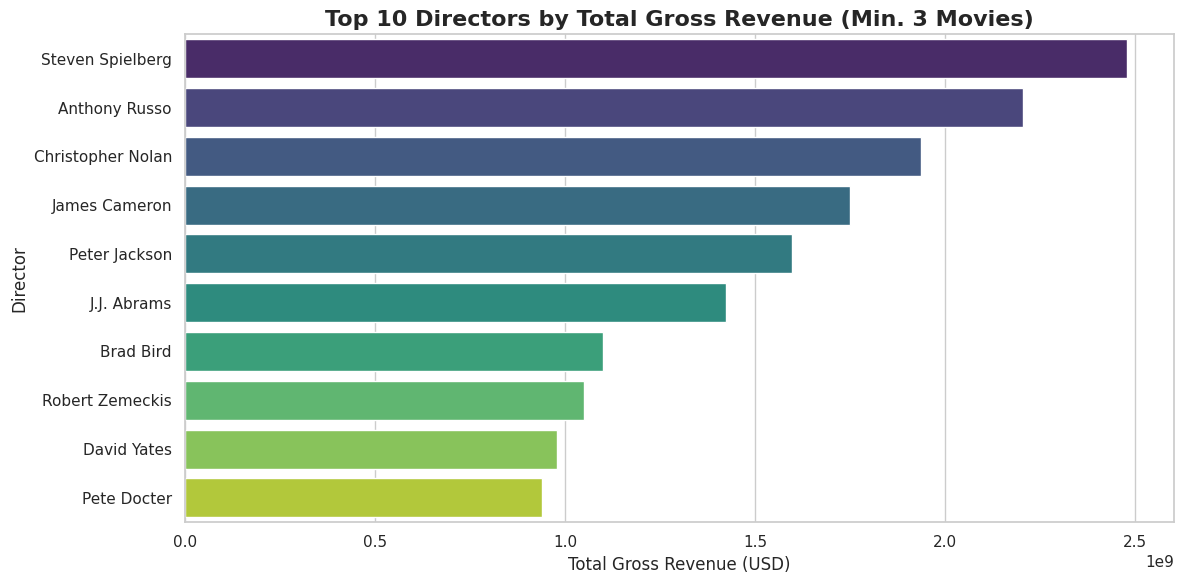

In [3]:
# --- DATA CLEANING ---
# Remove commas from 'Gross' and convert to numeric
if df['Gross'].dtype == 'O': 
    df['Gross'] = df['Gross'].str.replace(',', '', regex=False)

df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')

# Drop rows where Gross is NaN
df_clean = df.dropna(subset=['Gross']).copy()

# --- TASK 1: DIRECTOR ANALYSIS ---
# Filter: Directors with at least 3 movies
director_counts = df_clean['Director'].value_counts()
reliable_directors = director_counts[director_counts >= 3].index
df_directors = df_clean[df_clean['Director'].isin(reliable_directors)]

# Calculate Total Gross Revenue per Director
director_revenue = df_directors.groupby('Director')['Gross'].sum().sort_values(ascending=False)

# Select Top 10
top_10_directors = director_revenue.head(10)

# Visualization: Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_directors.values, y=top_10_directors.index, palette='viridis')

plt.title('Top 10 Directors by Total Gross Revenue (Min. 3 Movies)', fontsize=16, weight='bold')
plt.xlabel('Total Gross Revenue (USD)', fontsize=12)
plt.ylabel('Director', fontsize=12)
plt.tight_layout()

# Save plot
plt.savefig('director_revenue.png')
plt.show()

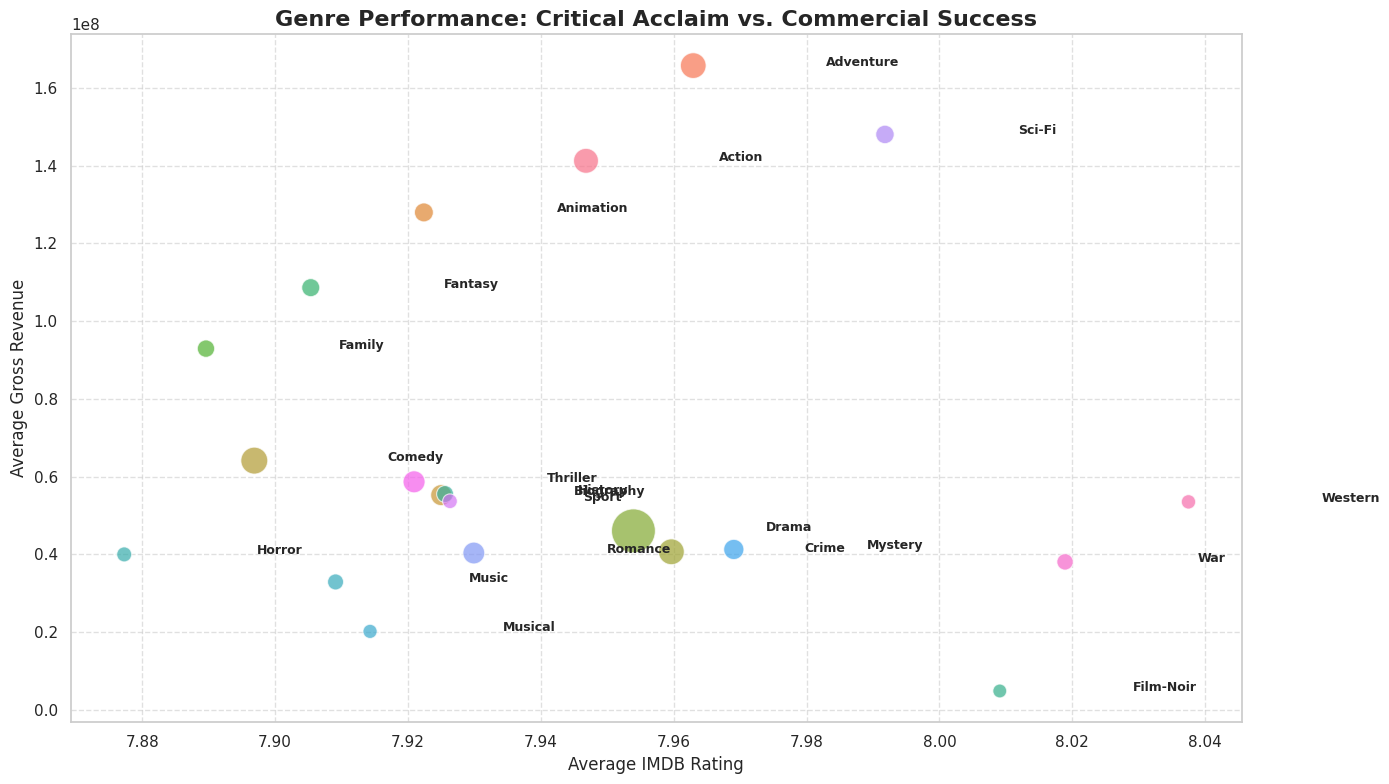

In [4]:
# --- TASK 2: GENRE ANALYSIS ---
# Data Transformation: Split and Explode the Genre column
df_clean['Genre_List'] = df_clean['Genre'].str.split(', ')
df_exploded = df_clean.explode('Genre_List')

# Aggregation: Avg Rating, Avg Gross, and Count per Genre
genre_stats = df_exploded.groupby('Genre_List').agg({
    'IMDB_Rating': 'mean',
    'Gross': 'mean',
    'Series_Title': 'count'
}).rename(columns={'Series_Title': 'Movie_Count'})

# Filtering: Remove genres with < 10 movies
genre_stats = genre_stats[genre_stats['Movie_Count'] >= 10]

# Visualization: Scatter Plot (Bubble Chart)
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=genre_stats,
    x='IMDB_Rating',
    y='Gross',
    size='Movie_Count',
    sizes=(100, 1000),
    hue=genre_stats.index,
    alpha=0.7,
    legend=False
)

# Label the bubbles
for genre in genre_stats.index:
    plt.text(
        genre_stats.loc[genre, 'IMDB_Rating'] + 0.02,
        genre_stats.loc[genre, 'Gross'],
        genre,
        fontsize=9,
        weight='bold'
    )

plt.title('Genre Performance: Critical Acclaim vs. Commercial Success', fontsize=16, weight='bold')
plt.xlabel('Average IMDB Rating', fontsize=12)
plt.ylabel('Average Gross Revenue', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save plot
plt.savefig('genre_analysis.png')
plt.show()